# Задание
Данные получены NASA в серии аэродинамических и акустический испытаний профиля сечения лопаток в аэродинамической трубе. 

1) Постройте модель линейной и квантильной регрессии. Проверьте выполнение регрессионных предположений. 

2) Выберете набор независимых переменных и постройте прогноз значения зависимой переменной для двух моделей вместе с доверительными интервалами для прогнозируемых значений.


In [20]:
df <- read.table("https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat")

In [21]:
colnames(df) <-  c('frequency',         # 1. Частота, Гц.
                    'angle',            # 2. Угол атаки, градусы.
                    'chord_length',     # 3. Длина хорды профиля лопатки, м.
                    'fs_velocity',      # 4. Скорость набегающего потока, м/с.
                    'ssd_thickness',    # 5. Толщина вытеснения на выпуклой стороне (спинке) лопатки, м.
                    'sound_level')      # 6. Уровень громкости, дБ.

In [22]:
head(df)

frequency,angle,chord_length,fs_velocity,ssd_thickness,sound_level
800,0,0.3048,71.3,0.00266337,126.201
1000,0,0.3048,71.3,0.00266337,125.201
1250,0,0.3048,71.3,0.00266337,125.951
1600,0,0.3048,71.3,0.00266337,127.591
2000,0,0.3048,71.3,0.00266337,127.461
2500,0,0.3048,71.3,0.00266337,125.571


# Линейная регрессия
Проверим линейную зависимость уровня громкости от остальных факторов. Сначала проверим коррелированность факторов.

In [23]:
correlations <- as.data.frame(as.table(cor(df[,c('frequency',     
                                                'angle',        
                                                'chord_length', 
                                                'fs_velocity',  
                                                'ssd_thickness')])))

In [24]:
correlations <- correlations[correlations$Var1 != correlations$Var2,]
correlations <- correlations[abs(correlations$Freq) > 0.5, ]

In [25]:
correlations

,Var1,Var2,Freq
8,chord_length,angle,-0.5048681
10,ssd_thickness,angle,0.7533938
12,angle,chord_length,-0.5048681
22,angle,ssd_thickness,0.7533938


Как видно угол атаки сильно коррелирует с толщиной вытеснения на выпуклой стороне и с длинной хорды. B задаче линейной регрессии $y=Xb + \varepsilon$ для метода МНК оценки коэффициентов можно получить по следующей формуле  $\hat{b}=(X^TX)^{-1}X^Ty$. Наличие строгой линейной зависмости между признаками ведет к вырожденности матрицы $(X^TX)$ и невозвожности однозначно получить оценки.

Рассмотрим случай $n=2$. Тогда матрица $\frac{1}{n}(X^TX)$ имеет следующий вид:
$$ \frac{1}{n}(X^TX) = \left[
\begin{array}{ccc}
	1 & \overline{x_1} & \overline{x_2} \\
	\overline{x_1} & \overline{x_1^2} & \overline{x_1x_2}\\
	\overline{x_2} & \overline{x_1x_2} & \overline{x_2^2}\\
\end{array} 
\right]
 $$
 
 Отсюда $$det \left(X^TX\right) = Var(x_1)Var(x_2) - Cov(x_1, x_2)^2$$
 
 В терминах коэффициента корреляции это равносильно
 $$det \left(X^TX\right)= Var(x_1)Var(x_2) \left( 1 - \rho(x_1, x_2)^2 \right)$$

Таким образом, когда $\rho(x_1, x_2) \approx 1$ определитель матрицы становится близок к нулю. Что влияет на вычисление обратной матрицы.

In [26]:
X = as.matrix(cbind(1, df[,c('frequency',
                            'angle',
                            'chord_length', 
                            'fs_velocity',  
                            'ssd_thickness')]))
X_a = as.matrix(cbind(1, df[,c('frequency',
                            'chord_length', 
                            'fs_velocity',  
                            'ssd_thickness')]))

In [27]:
det(t(X) %*% X)

[1] 3.757074e+23

In [28]:
det(t(X_a) %*% X_a)

[1] 2.457983e+19

Поскольку определитель $X^TX$ не близок к нулю, то мы не будем исключать признаки.

In [29]:
linear_model <- lm(sound_level ~ frequency + chord_length + fs_velocity + ssd_thickness + angle, data=df)

In [30]:
summary(linear_model)


Call:
lm(formula = sound_level ~ frequency + chord_length + fs_velocity + 
    ssd_thickness + angle, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-17.480  -2.882  -0.209   3.152  16.064 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    1.328e+02  5.447e-01  243.87   <2e-16 ***
frequency     -1.282e-03  4.211e-05  -30.45   <2e-16 ***
chord_length  -3.569e+01  1.630e+00  -21.89   <2e-16 ***
fs_velocity    9.985e-02  8.132e-03   12.28   <2e-16 ***
ssd_thickness -1.473e+02  1.501e+01   -9.81   <2e-16 ***
angle         -4.219e-01  3.890e-02  -10.85   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.809 on 1497 degrees of freedom
Multiple R-squared:  0.5157,	Adjusted R-squared:  0.5141 
F-statistic: 318.8 on 5 and 1497 DF,  p-value: < 2.2e-16


Как видно имеется линейная зависимость, поскольку 

1) Все коэффициенты линейной регрессии являются значимыми при уровне значимости 0.05. 

2) Также коэффициент $R^2$ значительно больше 0. 

3) При уровне значимости 0.05 нулевая гипотеза о равенстве коэффициентов нулю может быть отвергнута по Критерию Фишера поскольку p-value значительно меньше 0.05.

## Линейная регрессия: прогноз
Поскольку все вакторы имеют численный тип, то в качестве точки для прогноза можно выбрать точку со средним значением по каждому из факторов.

In [31]:
newdf <- as.data.frame.list(colMeans(df))
newdf

frequency,angle,chord_length,fs_velocity,ssd_thickness,sound_level
2886.381,6.782302,0.1365482,50.86075,0.01113988,124.8359


Перед построением прогноза необходимо убедиться, что остатки распределены согласно нормальному закону.

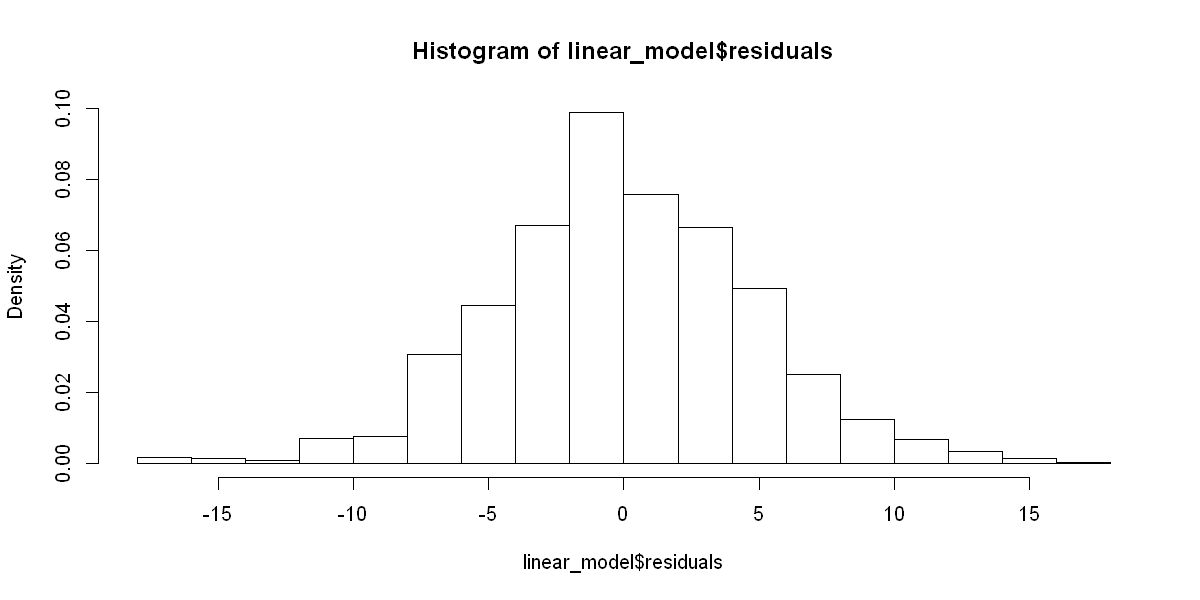

In [32]:
options(repr.plot.width = 10, repr.plot.height = 5)
hist(linear_model$residuals, probability = T)

In [33]:
shapiro.test(linear_model$residuals)


	Shapiro-Wilk normality test

data:  linear_model$residuals
W = 0.99563, p-value = 0.0002465


In [34]:
ks.test(linear_model$residuals, pnorm, mean(linear_model$residuals), sd(linear_model$residuals))


	One-sample Kolmogorov-Smirnov test

data:  linear_model$residuals
D = 0.027418, p-value = 0.2085
alternative hypothesis: two-sided


При уровне значимости 0.05 согласно критерию Шапиро–Уилка гипотеза о нормальности должна быть отвергнута.  
Но по критерию Колмогорова–Смирнова данные не противоречат гипотезе о нормальности.

Построим прогноз с доверительным 95% интервалом для выбранной точки.

In [35]:
predict(linear_model, newdf, interval="predict") 

,fit,lwr,upr
1,124.8359,115.4,134.2719


# Квантильная регрессия

In [36]:
library("quantreg")

Аналогично потсроим зависимости для квнтильной регрессии с квантилями 0.25, 0.5 и 0.75.

In [37]:
quantile_model <- rq(sound_level ~ frequency + chord_length + fs_velocity + ssd_thickness + angle,  data=df, tau=0.25)
summary(quantile_model, se="boot")


Call: rq(formula = sound_level ~ frequency + chord_length + fs_velocity + 
    ssd_thickness + angle, tau = 0.25, data = df)

tau: [1] 0.25

Coefficients:
              Value      Std. Error t value    Pr(>|t|)  
(Intercept)    129.99128    0.70360  184.75215    0.00000
frequency       -0.00144    0.00005  -28.80204    0.00000
chord_length   -30.55913    1.98135  -15.42337    0.00000
fs_velocity      0.10573    0.00884   11.96197    0.00000
ssd_thickness -174.67618   26.35196   -6.62858    0.00000
angle           -0.49486    0.06983   -7.08710    0.00000

In [38]:
quantile_model <- rq(sound_level ~ frequency + chord_length + fs_velocity + ssd_thickness, data=df, tau=0.5)
summary(quantile_model, se="boot")


Call: rq(formula = sound_level ~ frequency + chord_length + fs_velocity + 
    ssd_thickness, tau = 0.5, data = df)

tau: [1] 0.5

Coefficients:
              Value      Std. Error t value    Pr(>|t|)  
(Intercept)    131.83935    0.60770  216.94921    0.00000
frequency       -0.00148    0.00008  -18.63350    0.00000
chord_length   -29.39741    1.60024  -18.37066    0.00000
fs_velocity      0.09031    0.00951    9.49182    0.00000
ssd_thickness -303.96960   15.06719  -20.17428    0.00000

In [39]:
quantile_model <- rq(sound_level ~ frequency + chord_length + fs_velocity + ssd_thickness, data=df, tau=0.75)
summary(quantile_model, se="boot")


Call: rq(formula = sound_level ~ frequency + chord_length + fs_velocity + 
    ssd_thickness, tau = 0.75, data = df)

tau: [1] 0.75

Coefficients:
              Value      Std. Error t value    Pr(>|t|)  
(Intercept)    136.04258    0.70930  191.79905    0.00000
frequency       -0.00134    0.00010  -13.41199    0.00000
chord_length   -35.46116    1.96058  -18.08711    0.00000
fs_velocity      0.07373    0.01063    6.93479    0.00000
ssd_thickness -277.47876    9.59205  -28.92800    0.00000

Во всех случаях коэффициенты регрессии значимы. Заметим также, что для разных квантилей мы получили разные зависимости. То есть для лопаток с высоким уровнем шума и для лопаток с низким уровнем шума зависисмость от факторов различна.

## Квантильная регрессия: прогноз

Аналогично линейной регрессии построим прогноз для квантильной регрессии с квантилем 0.75

In [40]:
newdf <- as.data.frame.list(colMeans(df))
newdf

frequency,angle,chord_length,fs_velocity,ssd_thickness,sound_level
2886.381,6.782302,0.1365482,50.86075,0.01113988,124.8359


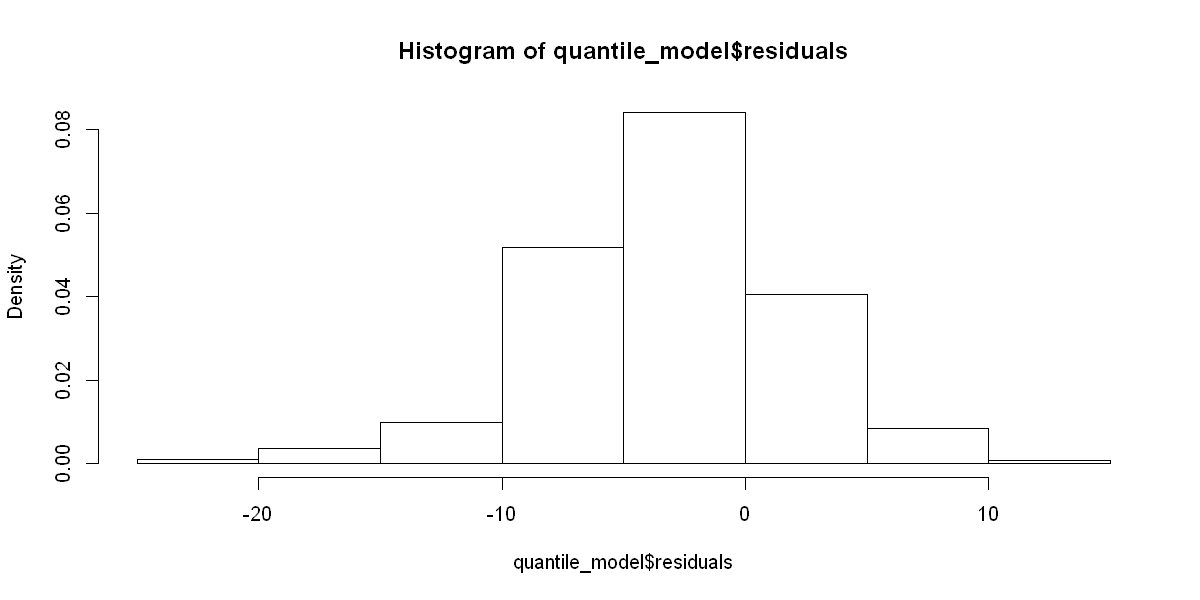

In [41]:
hist(quantile_model$residuals, probability = T)

In [42]:
shapiro.test(quantile_model$residuals)


	Shapiro-Wilk normality test

data:  quantile_model$residuals
W = 0.986, p-value = 7.024e-11


In [43]:
ks.test(linear_model$residuals, pnorm, mean(linear_model$residuals), sd(linear_model$residuals))


	One-sample Kolmogorov-Smirnov test

data:  linear_model$residuals
D = 0.027418, p-value = 0.2085
alternative hypothesis: two-sided


По-прежнему нормальность остатков отвергается критерием Шапиро–Уилка и принимается критерием Колмогорова–Смирнова.

In [44]:
predict(quantile_model, newdf, interval=c("confidence")) 

,fit,lower,higher
1,127.9901,127.5902,128.3899
